In [1]:
"""
#사용자 정의 손실함수

텐서플로우에서 기본으로 제공되는 손실함수 외에 사용자가 직접 정의한 손실함수를 정의하여
모델을 훈련시킬수 있다. 사용자 정의 손실함수를 만드는 방법은 간단하다.
함수를 정의하고 모델 컴파일 시 적용할 수 있다
"""
import tensorflow as tf
import numpy as np
#샘플 데이터 생성

X = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0], dtype=float)
Y = np.array([2.0, 4.0, 6.0, 8.0, 10.0, 12.0], dtype = float)

In [2]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=[1])
])

In [3]:
#사용자 정의 손실함수(Huber Loss 구현)
def custom_huber_loss(y_true, y_pred):
    #임계값 정의
    threshold = 1
    # 손실 계산
    error = y_true - y_pred
    
    small = tf.abs(error) <= threshold
    
    # 12 loss 적용
    small_error = tf.square(error) / 2
    
    #ll loss 적용
    big_error = threshold *(tf.abs(error) -(threshold / 2))
    
    # return
    return tf.where(small, small_error, big_error)


In [4]:
# 사용자 정의 custom_huber_loss 함수를 적용
model.compile(optimizer="sgd", loss=custom_huber_loss) 
model.fit(X, Y, epochs=1000, verbose=0)

# 결과 확인
print(model.predict([6.0]))

[[14.056862]]


In [5]:
"""
#사용자 정의 레이어
레이어도 사용자가 직접 정의하여 모델에 적용할 수 있다. 텐서플로우가 제공하는 레이어를 
상속 받아 필요한 부분만 수정해 변경할 수 있고 완전히 새로운 레이어를 정의하여 사용할 수도 있다

다음 코드와 같이 tf.keras의 Layer 클래스를 상속받아 쉽게 구현할 수 있다.
Dense 레이어를 직접 구현한 예시

"""

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer

In [6]:
class MyDense(Layer):
    def __init__(self, units=32, input_shape=None):
        super(MyDense, self).__init__(input_shape=input_shape)
        self.units = units
        
    def build(self, input_shape):
        # weight 초기화
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(name="weight",
                            initial_value = w_init(shape=(input_shape[-1], self.units),
                                                  dtype="float32"),trainable=True)
    
        #bias 초기화
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name="bias",
                            initial_value = b_init(shape=(self.units), dtype="float32"), trainable=True)

    def call(self, inputs):
        #wx + b
        return tf.matmul(inputs, self.w) + self.b

In [7]:
"""
Dense 레이어를 사용하지 않고, 직접 Layer를 상속받아 구현한 MyDense 클래스를 활용하여 모델을 생성하고
훈련해 결과를 확인한다 
"""
#샘플 데이터 생성

X = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0], dtype=float)
Y = np.array([2.0, 4.0, 6.0, 8.0, 10.0, 12.0], dtype = float)

# 사용자 정의 MyDense 레이어를 적용한 경우
model = tf.keras.Sequential([
    MyDense(units=1, input_shape=[1])
])

# 컴파일
model.compile(optimizer ="sgd", loss="mse")

#훈련
model.fit(X, Y, epochs=1000, verbose=0)

#결과 확인
print(model.predict([6.0]))

[[14.002444]]


In [8]:
"""
#사용자 정의 훈련

train_on_batch
지금까지 모델을 훈련할 때 fit() 메소드 훈련을 진행했다 fit()메소드를 사용하면 
전체 배치에 대하여 훈련을 진행한 후 1epoch가 끝나면 전체 훈련 손실함수와 평가지표를 보여준다

한편 train_on_batch()를 활용하면 배치별로 구분해서 훈련을 진행할 수 있다.
먼저 실습을 위해 mnist 데이터셋을 로드하고 정규화를 진행

"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#ㅔ라스의 내장 데이터셋에서 mnist 데이터셋 로드
mnist = tf.keras.datasets.mnist

#load_data()로 데이터셋 로드
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 정규화
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()


In [9]:
"""
Sequential API를 활용하여 모델 생성 후  컴파일
"""
# 모델정의 
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    # 노드=10개가 되어야 한다
    tf.keras.layers.Dense(10, activation="softmax"),
])

#모델 컴파일
model.compile(optimizer = "adam", loss="sparse_categorical_crossentropy", metrics = ["accuracy"])


In [10]:
"""
배치별로 구분해 학습을 진행하기 위해서 배치를 생성하는 함수를 구현한다
batch_size의 기본값으로 32개로 설정해 batch_size를 원하는 크기로 조절할 수 있다
함수의 반복문 내부에서는 x,y의 쌍으로 묶인 1개의 배치를 생성한 훈 반환한다.
이때 yield 키워드를 지정했는데, yield 키워드는 for 루프가 실행될 때 yield 키워드를 
만나기 전까지 실행하고 해당 루프에 대한 결과를 반환하며 다음 함수를 호출할 때
다음 루프가 실행되어 결과를 반환한다
"""
#배치 생성 함수
def get_batches(x, y, batch_size =32):
    for i in range(int(x.shape[0] // batch_size)):
        x_batch = x[i * batch_size:(i + 1) * batch_size]
        y_batch = y[i * batch_size:(i + 1) * batch_size]
        yield(np.asarray(x_batch), np.asarray(y_batch))

In [11]:
"""
yield로 반환하는 함수는 파이썬 제네레이터(generator)가 되며, 제너레이터에서 값을
반환받기 위해서 next 키워드를 사용하면 된다
1개의 배치를 반환할 때 batch_size =32 로 지정 했기 때문에 32개의 x,y 데이터가 투플 형식의 쌍으로 반환된다

"""
#1개의 배치로드
x, y = next(get_batches(x_train, y_train))
x.shape, y.shape

((32, 28, 28), (32,))

epoch:1, batch:50, batch_loss:0.3528, batch_accuracy:0.8594, avg_loss:1.083942
epoch:1, batch:100, batch_loss:0.4434, batch_accuracy:0.8828, avg_loss:0.753536
epoch:1, batch:150, batch_loss:0.2145, batch_accuracy:0.9375, avg_loss:0.611040
epoch:1, batch:200, batch_loss:0.2467, batch_accuracy:0.9219, avg_loss:0.521644
epoch:1, batch:250, batch_loss:0.1875, batch_accuracy:0.9531, avg_loss:0.467823
epoch:1, batch:300, batch_loss:0.2998, batch_accuracy:0.9219, avg_loss:0.426079
epoch:1, batch:350, batch_loss:0.1293, batch_accuracy:0.9688, avg_loss:0.394236
epoch:1, batch:400, batch_loss:0.1189, batch_accuracy:0.9688, avg_loss:0.373148
epoch:1, batch:450, batch_loss:0.1540, batch_accuracy:0.9375, avg_loss:0.350134


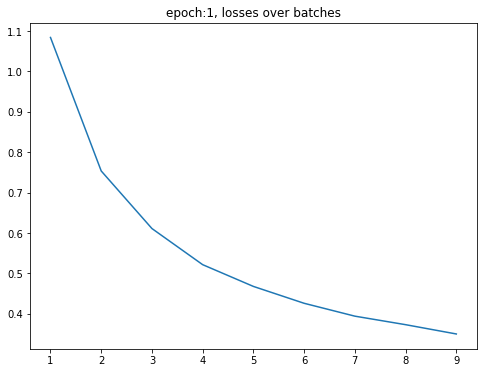

313/313 [==============================] - 1s 2ms/step - loss: 0.1637 - accuracy: 0.9493
----------------------------------------
epoch:1, val_loss:0.163655, val_accuracy:0.949300

epoch:2, batch:50, batch_loss:0.0636, batch_accuracy:0.9844, avg_loss:0.142231
epoch:2, batch:100, batch_loss:0.1924, batch_accuracy:0.9531, avg_loss:0.149453
epoch:2, batch:150, batch_loss:0.1077, batch_accuracy:0.9766, avg_loss:0.145191
epoch:2, batch:200, batch_loss:0.2104, batch_accuracy:0.9531, avg_loss:0.140261
epoch:2, batch:250, batch_loss:0.1162, batch_accuracy:0.9688, avg_loss:0.138698
epoch:2, batch:300, batch_loss:0.1893, batch_accuracy:0.9453, avg_loss:0.135346
epoch:2, batch:350, batch_loss:0.0707, batch_accuracy:0.9844, avg_loss:0.132288
epoch:2, batch:400, batch_loss:0.0786, batch_accuracy:0.9688, avg_loss:0.133683
epoch:2, batch:450, batch_loss:0.1093, batch_accuracy:0.9531, avg_loss:0.129811


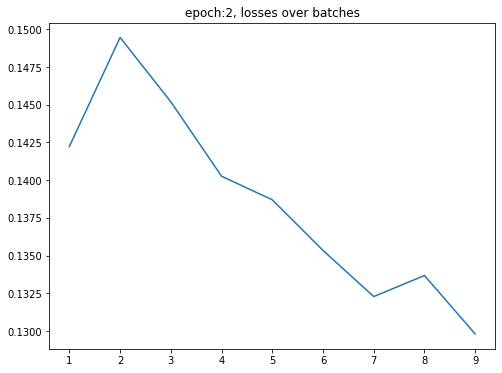

313/313 [==============================] - 1s 3ms/step - loss: 0.1098 - accuracy: 0.9661
----------------------------------------
epoch:2, val_loss:0.109803, val_accuracy:0.966100

epoch:3, batch:50, batch_loss:0.0358, batch_accuracy:0.9922, avg_loss:0.093518
epoch:3, batch:100, batch_loss:0.1185, batch_accuracy:0.9766, avg_loss:0.095092
epoch:3, batch:150, batch_loss:0.0976, batch_accuracy:0.9766, avg_loss:0.090706
epoch:3, batch:200, batch_loss:0.1606, batch_accuracy:0.9688, avg_loss:0.089746
epoch:3, batch:250, batch_loss:0.0665, batch_accuracy:0.9844, avg_loss:0.090007
epoch:3, batch:300, batch_loss:0.1250, batch_accuracy:0.9688, avg_loss:0.088109
epoch:3, batch:350, batch_loss:0.0422, batch_accuracy:0.9844, avg_loss:0.086549
epoch:3, batch:400, batch_loss:0.0492, batch_accuracy:0.9766, avg_loss:0.087051
epoch:3, batch:450, batch_loss:0.0536, batch_accuracy:0.9844, avg_loss:0.084525


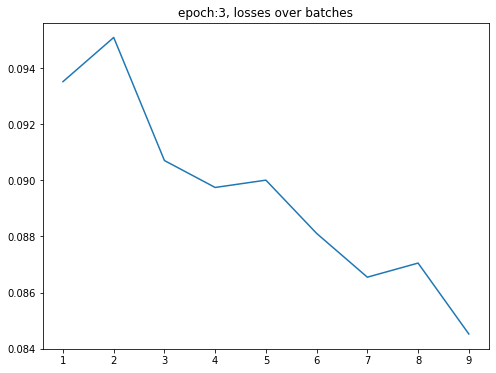

313/313 [==============================] - 1s 3ms/step - loss: 0.1241 - accuracy: 0.9602
----------------------------------------
epoch:3, val_loss:0.124079, val_accuracy:0.960200



In [12]:
"""
모델 인스턴스의 train_on_batch() 메소드를 사용해 훈련할 때는 각 배치에 대한 반복훈련이
필요하다. 먼저 epoch를 반복할 루프를 정의하고 루프 안에서 이전에 정의한 get_batches()
제너레이터를 통해 x,y를 반환받아 train_on_batch() 메소드에 매개변수로 입력한다
train_on_batch() 메소드를 호출할 때 1개 배치에 대한 훈련을 진행하며 손실과 평가지표에
대한 결과를 반환한다
배치별 손실을 누적으로 합하여 전체 배치의 개수로 나누어 주면 평균 손실을 산출할 수 있다
또한, 배치별 손실을 리스트에 추가하여 1 epoch의 훈련이 끝난 후 배치별 손실 변화를 시각화 할수 있다
"""
MONITOR_STEP = 50

for epoch in range(1, 4):
    batch =1
    total_loss = 0
    losses= []
    for x, y in get_batches(x_train, y_train, batch_size=128):
        # 배치별 훈련
        loss, acc = model.train_on_batch(x, y)
        total_loss += loss
        
        
        #출력
        if batch % MONITOR_STEP ==0:
            losses.append(total_loss / batch)
            print(f"epoch:{epoch}, batch:{batch}, batch_loss:{loss:.4f}, batch_accuracy:{acc:.4f}, avg_loss:{total_loss / batch :4f}" )
            
        batch += 1
        
    # Loss 시각화
    plt.figure(figsize = (8, 6))
    plt.plot(np.arange(1, batch // MONITOR_STEP+1), losses)
    plt.title(f"epoch:{epoch}, losses over batches")
    plt.show()
    
    # 결과 출력
    loss, acc = model.evaluate(x_test, y_test)
    print("----" * 10)
    print(f"epoch:{epoch}, val_loss:{loss:4f}, val_accuracy:{acc:4f}")
    print()
    

In [13]:
"""
50개의 배치 훈련이 끝난 후 전체 손실에 대한 평균을 구한 뒤 리스트에 추가 했다
하나의 epoch 훈련을 마친 후 배치별 손실의 평균을 시각화하여 변화를 확인한다

모델 인스턴스의 fit()메소드를 활용해 모델을 훈련할 때 배치별 훈련을 제어하거나 매 epoch가
끝날 때마다 시각화가 어렵다는 단점이 존재하지만, train_on_batch()메소드를 활용하여 
배치 훈련이 완료된 뒤 다양한 로직을 직접 구현해 줌으로써 훈련을 모디터링 할 수 있다
"""

'\n50개의 배치 훈련이 끝난 후 전체 손실에 대한 평균을 구한 뒤 리스트에 추가 했다\n하나의 epoch 훈련을 마친 후 배치별 손실의 평균을 시각화하여 변화를 확인한다\n\n모델 인스턴스의 fit()메소드를 활용해 모델을 훈련할 때 배치별 훈련을 제어하거나 매 epoch가\n끝날 때마다 시각화가 어렵다는 단점이 존재하지만, train_on_batch()메소드를 활용하여 \n배치 훈련이 완료된 뒤 다양한 로직을 직접 구현해 줌으로써 훈련을 모디터링 할 수 있다\n'

In [14]:
"""
# 자동 미분
텐서플로우는 그래디언트를 손쉽게 업데이트할 수 있는 자동 미분 기능을 지원한다
자동 미분은 tf.GradientTape()을 통해 계산 과정을 기록한 뒤 gradient() 메소드로 미분을 
계산할 수 있다. 다음은 자동 미분 기능을 활용한 그래디언트를 구하는 과정

"""
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# a,b 의 Variable를 생성
a = tf.Variable([1, 2, 3, 4, 5], dtype=tf.float32)
b = tf.Variable([10, 20, 30, 40, 50], dtype=tf.float32)

#미분 계산을 위해서 a, b가 미분 가능한 객체인지 확인
print(f"a.trainabel: {a.trainable} - b.trainable: {b.trainable}")

a.trainabel: True - b.trainable: True


In [15]:
"""
tf.GradientTape()의 범위를 정의하고 tape으로 지정
"""

# c =a * b
# c를 a 대한 편미분 => b
# c를 b 대한 편미분 => c

with tf.GradientTape() as tape:
    c = a * b
grads = tape.gradient(c, [a ,b])
tf.print(f"dc/da: {grads[0]}")
tf.print(f"dc/db: {grads[1]}")

dc/da: [10. 20. 30. 40. 50.]
dc/db: [1. 2. 3. 4. 5.]


In [16]:
x = tf.Variable(np.random.normal(size=(100)), dtype=tf.float32)
y = 2 * x + 3
print(f"x[:5]: {x[:5].numpy()} - ny[:5]: {y[:5].numpy()}")

x[:5]: [-0.51533717  0.69338655 -1.385418    1.4149514  -0.4441741 ] - ny[:5]: [1.9693257  4.386773   0.22916389 5.8299026  2.111652  ]


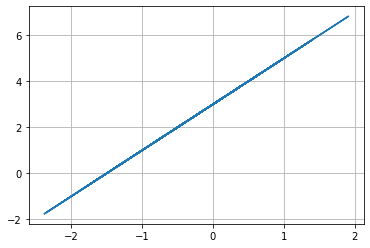

In [17]:
"""
x 는 100개의 난수를 생성하였으며 y에는 2x + 3으로 나온 결과를 저장한다 
즉 w = 2, b=3 이다 
그리고 x, y를 시각화하면 기울기가 2이고 절편이 3인 1차 함수 그래프가 생성된다
"""

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x.numpy(), y.numpy())
ax.grid()
plt.show()

In [20]:
"""
tf.GradientTape() 학습 
"""
#학습률, 최대 epoch 정의
learning_rate = 0.25
EPOCHS = 100

# w, b 초기값을 0.0 으로 설정, float 타입을 가져야 함
w = tf.Variable(0.0)
b = tf.Variable(0.0)

for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:
        # y_hat(예측 값)
        y_hat = w * x + b
        
        #손실 계산(MSE)
        loss = tf.reduce_mean((y_hat - y)**2)
        
    #그래디언트 계산
    dw, db = tape.gradient(loss, [w, b])
    
    #그래디언트 업데이트
    w = tf.Variable(w - learning_rate * dw)
    b = tf.Variable(b - learning_rate * db)
    
    print(f"epoch: {epoch}, loss:{loss.numpy(): 4f}, w:{w.numpy(): 4f}, b{b.numpy() :4f}")
    
    #Error가 0.0005보다 작으면 루프 종료
    if loss.numpy() < 0.0005:
        break

epoch: 0, loss: 10.102898, w: 0.548748, b1.317984
epoch: 1, loss: 3.671325, w: 0.991970, b2.026917
epoch: 2, loss: 1.424836, w: 1.317597, b2.421720
epoch: 3, loss: 0.573431, w: 1.545359, b2.648756
epoch: 4, loss: 0.235099, w: 1.700198, b2.783002
epoch: 5, loss: 0.097267, w: 1.803634, b2.864217
epoch: 6, loss: 0.040418, w: 1.871961, b2.914237
epoch: 7, loss: 0.016830, w: 1.916765, b2.945466
epoch: 8, loss: 0.007015, w: 1.946002, b2.965158
epoch: 9, loss: 0.002925, w: 1.965018, b2.977665
epoch: 10, loss: 0.001220, w: 1.977359, b2.985649
epoch: 11, loss: 0.000509, w: 1.985356, b2.990764
epoch: 12, loss: 0.000212, w: 1.990532, b2.994049


In [21]:
"""
# 자동 미분을 활용한 모델 훈련

지금까지 모델 인스턴스의 fit() 메소드로 모델을 훈련했다면, 이번에는 텐서플로의 자동 미분
기능을 활용하여 모델 훈련을 진행한다. Sequential API를 활용하여 간단한 모델을 생성

그리고 손실함수와 옵티마이저를 정의하는 모델 인스턴스의 컴파일 메소드를 사용하여 
정의하지 않고 클래스 인스턴스로  생성해 변수에 저장한다
"""
# 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
])

#손실함수 정의
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

#옵티마이저 정의
optimizer = tf.keras.optimizers.Adam()



In [22]:
"""
평가지표
"""
#기록을 위한 Metric 정의
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = "train_accuracy")
valid_loss = tf.keras.metrics.Mean(name="valid_loss")
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name= "valid_accuracy")
optimizer = tf.keras.optimizers.Adam()

In [23]:
# 배치 생성 함수
def get_batches(x, y, batch_size =32):
    for i in range(int(x.shape[0] // batch_size)):
        x_batch = x[i * batch_size:(i + 1) * batch_size]
        y_batch = y[i * batch_size:(i + 1) * batch_size]
        yield(np.asarray(x_batch), np.asarray(y_batch))

In [ ]:
"""
8은 여기까지 - 배워본적이 없던거라 조금 어렵네 시간상 다음에 
그리고 이거 활용을 어디다가 해야하는지 이해가 아지 안됨
"""